<a href="https://colab.research.google.com/github/alexantaki16/covid/blob/master/Code/covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Can we diagnosis Covid, Pneumonia, or Normal Chest X Rays with computer vision?

I am going to use TensorFlow for this project.  

## What will this notebook cover?
I am going to go show you:
* EDA
* Prepreocessing
* Model Building
* Model Evaluation
* Model Enhancement
* Plotting our loss curves

## Get the data for your own models!
The data is from Kaggle.  Click [here](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) to view it!

Are you ready?  Let's go.

#1 Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.optimizers import Adam
from keras.models import Sequential

import math

import os
from google.colab import drive

!pip install split_folders
import splitfolders

#2 Import the data

> Note: The data will be redownloaded every time we run this.  It is automatic, however, it is good to know :).

In [3]:
from google.colab import drive
drive.mount("/content/gdrive/")

#This will connect to our kaggle.json document
os.environ["KAGGLE_CONFIG_DIR"] = "/content/gdrive/My Drive/"

#This will download the dataset directly into the colab 
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

#Unzip the file
!unzip covid19-radiography-database.zip

#Navigate to the directory the data is in
os.chdir("/content/COVID-19_Radiography_Dataset/")

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

# 3.1 Explore the data

* What type of data are we dealing with?
  - Images
* What are the shapes?
* Are the other ways for us to learn about the data?
  - Metadata files
* Are there any imbalances?

In [4]:
#Import all of the metadata files to view
covid_metadata = pd.read_excel("COVID.metadata.xlsx")
normal_metadata = pd.read_excel("Normal.metadata.xlsx")
viral_pneumonia_metadata = pd.read_excel("Viral Pneumonia.metadata.xlsx")

#What can we learn before we plot?
* We can see the first few rows of data to be certain our data is in.
  - `head()`
* We can see the last few rows to get a sense of the size of the data
  - `tail()`
* We can see the description of the dataframes too.
  - `describe()`
* We can see the info of the dataframe.
  - `info()`
* We can see the column names of the dataframe.
  - `.columns`
* We can see the data types of the columns
  - `dtypes()`
* We can see if we have missing values
  - `isna()`
* We can see the shape
  - `.shape`

Let's make a helper function so reduce our code

In [5]:
def separate_learning_functions():
  """
  Summary: This provides clean spacing to help separate the pandas functions

  Descrtiption:  After this cell, we have a "learn_about_covid_metadata()" function.
  I am using this function to reduce the amount of code.  Modularizing code is a great skill.

  Params: None

  Return: None
  """
  print()
  print("=" * 100)
  print()
  print("#" * 100)

In [6]:
def get_df_name(dataframe):
    """
    Summary:  This is a function from Stack Overflow. https://stackoverflow.com/questions/31727333/get-the-name-of-a-pandas-dataframe

    Description:  Thank you for sharing this function

    Parameters: A dataframe

    Return: The dataframe name
    """
    name =[x for x in globals() if globals()[x] is dataframe][0]
    return name

In [7]:
def learn_about_dataframes(dataframe):
  dataframe_name = get_df_name(dataframe)

  print("#" * 50, dataframe_name.upper(), "#" * 50)
  print("+" * 45, "Head Method", "+" * 45)
  print(dataframe.head())
  print("+" * 40, "End Head Method", "+" * 40)

  separate_learning_functions()

  print("+" * 40, "Tail Method", "+" * 40)
  print(dataframe.tail())
  print("+" * 40, "End Tail Method", "+" * 40)

  separate_learning_functions()

  print("+" * 40, "Describe Method", "+" * 40)
  print(dataframe.describe())
  print("+" * 40, "End Describe Method", "+" * 40)

  separate_learning_functions()

  print("+" * 40, "Info Method", "+" * 40)
  print(dataframe.info())
  print("+" * 40, "End Info Method", "+" * 40)

  separate_learning_functions()

  print("+" * 40, "Columns Method", "+" * 40)
  print(dataframe.columns)
  print("+" * 40, "End Columns Method", "+" * 40)

  separate_learning_functions()

  print("+" * 40, "isna Method", "+" * 40)
  print(dataframe.isna())
  print("+" * 40, "End isna Method", "+" * 40)

  separate_learning_functions()

  print("+" * 40, "Shape Method", "+" * 40)
  print(dataframe.shape)
  print("+" * 40, "Shape Method", "+" * 40)

  separate_learning_functions()

  print("#" * 40, "End", dataframe_name.upper(), "#" * 40)
  print("#" * 100)

In [8]:
learn_about_dataframes(covid_metadata)

################################################## COVID_METADATA ##################################################
+++++++++++++++++++++++++++++++++++++++++++++ Head Method +++++++++++++++++++++++++++++++++++++++++++++
  FILE NAME FORMAT     SIZE                                                URL
0   COVID-1    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
1   COVID-2    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
2   COVID-3    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
3   COVID-4    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
4   COVID-5    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
++++++++++++++++++++++++++++++++++++++++ End Head Method ++++++++++++++++++++++++++++++++++++++++


####################################################################################################
++++++++++++++++++++++++++++++++++++++++ Tail Method ++++++++++++++++++++++++++++++++++++++++
       FIL

#What is the Covid metadata learning function telling us?

- `head()`
  - The dataframe imported successfully.
  - It looks like we have 4 columns (file name, format, pixel density, and the url)
  - The pixels are 256 * 256
- `tail()`
  - There are 3615 rows
- `describe()`
  - There are 3615 counts of images which means every image is unique.  Sweet.
- `info()`
  - We can see the fours columns is correct
  - They are all objects but that is okay since we are using this to help us understand the data.  This is not going to be in the model section.
- `isna()`
  - We can see the False statements showing us there is no missing data.  This is only a snippet so do not assume that means everything is there.
- `shape`
  - The shape of the dataframe is 3615 x 4 which makes sense.  The top row is includes so it says there is one more row than I wrote here.  The 4 columns is confirmed yet again.

In [9]:
learn_about_dataframes(viral_pneumonia_metadata)

################################################## VIRAL_PNEUMONIA_METADATA ##################################################
+++++++++++++++++++++++++++++++++++++++++++++ Head Method +++++++++++++++++++++++++++++++++++++++++++++
           FILE NAME  ...                                                URL
0  Viral Pneumonia-1  ...  https://www.kaggle.com/paultimothymooney/chest...
1  Viral Pneumonia-2  ...  https://www.kaggle.com/paultimothymooney/chest...
2  Viral Pneumonia-3  ...  https://www.kaggle.com/paultimothymooney/chest...
3  Viral Pneumonia-4  ...  https://www.kaggle.com/paultimothymooney/chest...
4  Viral Pneumonia-5  ...  https://www.kaggle.com/paultimothymooney/chest...

[5 rows x 4 columns]
++++++++++++++++++++++++++++++++++++++++ End Head Method ++++++++++++++++++++++++++++++++++++++++


####################################################################################################
++++++++++++++++++++++++++++++++++++++++ Tail Method +++++++++++++++++++++++++++++++

#What is the Viral Pnemonia metadata learning telling us?

- `head()`
  - The dataframe imported successfully
  - There are four columns again.  They are file name, format (peg), pixel density, and url.
- `tail()`
  - We are handling 1344 rows of data.  That is a noticebale difference from the Covid one.  The previous one has 3616.  We have over 2.5x the amount.  Hmm.  Class imbalance magic will be helpful.  Maybe augment one dataset and not the other 🤔.
- `describe()`
  - There are 1345 unique columns 
- `info()`
  - This confirms the four columns and we are dealing with object since it is text but that is okay.
- `columns`
  - We can see the four columns.
- `isna()`
  - This tells us that there are no missing values.  It is not the whole dataset, be careful and do not assume that everything is good to go.
- `shape`
  - The shape is 1345, 4.  That confirms the 1345 rows from the tail and the four columns from info and columns

In [10]:
learn_about_dataframes(normal_metadata)

################################################## NORMAL_METADATA ##################################################
+++++++++++++++++++++++++++++++++++++++++++++ Head Method +++++++++++++++++++++++++++++++++++++++++++++
  FILE NAME FORMAT     SIZE                                                URL
0  NORMAL-1    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
1  NORMAL-2    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
2  NORMAL-3    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
3  NORMAL-4    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
4  NORMAL-5    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
++++++++++++++++++++++++++++++++++++++++ End Head Method ++++++++++++++++++++++++++++++++++++++++


####################################################################################################
++++++++++++++++++++++++++++++++++++++++ Tail Method ++++++++++++++++++++++++++++++++++++++++
         

#What is the Normal metadaa learning function telling us?

- `head()`
  - The dataframe import successfull
- `tail()`
  - We have 10191 rows
- `describe()`
  - We have all unique images
- `info()`
  - We know we have a full dataset with 10191 rows and 4 columns
- `columns`
  - There are definitely four columns only
- `isna()`
  - We can see everything is false which is good.  This does not mean everything is false.
- `shape`
  - This shape = 10192, 4.  This confirms the row / column count

# The Key Takeaway
- Covid = 3616 images
- Pneumonia = 1345 images
- Normal = 10191 images

We need to fix this.

#3.2 Explore random images

In [11]:
def view_random_image(target_dir, target_class):
  """
  This is from a course I am taking on Zero to Mastery.
  Here is a link: https://academy.zerotomastery.io/p/learn-tensorflow
  """
  #Setup target directory
  target_folder = target_dir + target_class

  #Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img

In [12]:
pathways = ["COVID", "Viral Pneumonia", "Normal"]
covid_path = "/content/COVID-19_Radiography_Dataset/" + pathways[0] 
viral_pneumonia_path = "/content/COVID-19_Radiography_Dataset/" + pathways[1]
normal_path = "/content/COVID-19_Radiography_Dataset/" + pathways[2]

def view_random_image():

  def randomize_file():
    return random.choice(os.listdir(path))

  def print_random_filename(random_file):
    random_filename = random_file.split(".png")[0]
    print(random_filename)


  def covid_img():
    random_file = random.choice(os.listdir(covid_path))

    covid_img = mpimg.imread("/content/COVID-19_Radiography_Dataset/COVID/" + random_file)
    plt.imshow(covid_img)
    plt.title(random_file)
    print("Image shape: ", covid_img.shape)

  def pneumonia_img():
    random_file = random.choice(os.listdir(viral_pneumonia_path))

    plt.figure()
    viral_pneumonia_img = mpimg.imread("/content/COVID-19_Radiography_Dataset/Viral Pneumonia/" + random_file)
    plt.imshow(viral_pneumonia_img)
    plt.title(random_file)
    print("Image shape: ", viral_pneumonia_img.shape)

  def normal_img():
    random_file = random.choice(os.listdir(normal_path))
    plt.figure()
    normal_img = mpimg.imread("/content/COVID-19_Radiography_Dataset/Normal/" + random_file)
    plt.imshow(normal_img)
    plt.title(random_file)
    print("Image shape: ", normal_img.shape)

  covid_img()
  pneumonia_img()
  normal_img()

Image shape:  (299, 299)
Image shape:  (299, 299)
Image shape:  (299, 299)


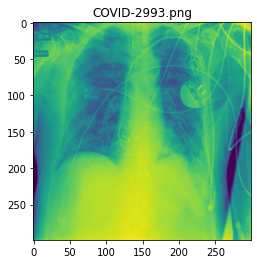

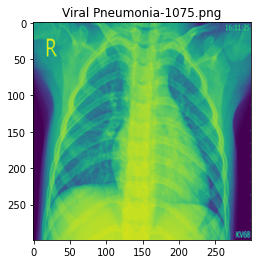

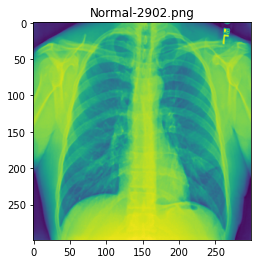

In [13]:
view_random_image()

# Preprocessing

Let's make our ImageDataGenerators with no augmentation for now

In [14]:
"""
os.chdir("/content/COVID-19_Radiography_Dataset/training/COVID")

covid = []
for file in os.listdir():
  covid.append(file)
covid_train = covid[:2894]
covid_test = covid[2894:]


os.chdir("/content/COVID-19_Radiography_Dataset/training/Viral Pneumonia")


viral_pneumonia = []
for file in os.listdir():
  viral_pneumonia.append(file)
viral_pneumonia_train = viral_pneumonia[:1076]
viral_pneumonia_test = viral_pneumonia[1076:]


os.chdir("/content/COVID-19_Radiography_Dataset/training/Normal")


normal = []
for file in os.listdir():
  normal.append(file)
normal_train = normal[:8153]
normal_test = normal[8153:]

training_data = covid_train + viral_pneumonia_train + normal_train
testing_data = covid_test + viral_pneumonia_test + normal_test
"""

'\nos.chdir("/content/COVID-19_Radiography_Dataset/training/COVID")\n\ncovid = []\nfor file in os.listdir():\n  covid.append(file)\ncovid_train = covid[:2894]\ncovid_test = covid[2894:]\n\n\nos.chdir("/content/COVID-19_Radiography_Dataset/training/Viral Pneumonia")\n\n\nviral_pneumonia = []\nfor file in os.listdir():\n  viral_pneumonia.append(file)\nviral_pneumonia_train = viral_pneumonia[:1076]\nviral_pneumonia_test = viral_pneumonia[1076:]\n\n\nos.chdir("/content/COVID-19_Radiography_Dataset/training/Normal")\n\n\nnormal = []\nfor file in os.listdir():\n  normal.append(file)\nnormal_train = normal[:8153]\nnormal_test = normal[8153:]\n\ntraining_data = covid_train + viral_pneumonia_train + normal_train\ntesting_data = covid_test + viral_pneumonia_test + normal_test\n'

In [16]:
#os.chdir("/content/COVID-19_Radiography_Dataset/training")
!mkdir training_split

#Copy the data to the training split folder

In [17]:
os.chdir("/content/COVID-19_Radiography_Dataset/training_split")

In [19]:
splitfolders.ratio("/content/COVID-19_Radiography_Dataset/training_split/", output="data", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 15153 files [00:04, 3319.58 files/s]


In [24]:
train_dir = "/content/COVID-19_Radiography_Dataset/training_split/data/train/"
test_dir = "/content/COVID-19_Radiography_Dataset/training_split/data/val/"

#os.chdir("/content/COVID-19_Radiography_Dataset/training_split/data/train/")
#!rm -r .ipynb_checkpoints/

#os.chdir("/content/COVID-19_Radiography_Dataset/training_split/data/val/")
#!rm -r .ipynb_checkpoints/

In [25]:
train_datagen = ImageDataGenerator(rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [26]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (299, 299),
                                               class_mode = "categorical",
                                               batch_size = 32,
                                               shuffle = True)

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size = (299, 299),
                                              class_mode = "categorical",
                                              batch_size = 32,
                                              shuffle = True)

Found 12121 images belonging to 3 classes.
Found 3032 images belonging to 3 classes.


# Models!

## Model 1 of 10

* This is the baseline.  Let's build it and then beat it with model 2!

In [27]:
#1 Build the baseline mode;

model_1 = Sequential([
  Conv2D(10, 3, activation = "relu", input_shape = (299, 299, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation = "relu"),
  MaxPool2D(),
  Conv2D(10, 3, activation = "relu"),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation = "softmax")
])

#2 Compile the model
model_1.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = Adam(),
                metrics = ["accuracy"])

#3 Fit the model
history_1 = model_1.fit(train_data,
                        epochs = 30,
                        validation_data = test_data,
                        steps_per_epoch = math.ceil(len(train_data) / 32),
                        validation_steps = math.ceil(len(test_data) / 32))

Epoch 1/30
12/12 [==============================] - 21s 2s/step - loss: 0.9034 - accuracy: 0.6703 - val_loss: 0.7519 - val_accuracy: 0.7188
Epoch 2/30
12/12 [==============================] - 20s 2s/step - loss: 0.8996 - accuracy: 0.6161 - val_loss: 0.7374 - val_accuracy: 0.6562
Epoch 3/30
12/12 [==============================] - 20s 2s/step - loss: 0.7273 - accuracy: 0.6773 - val_loss: 0.6707 - val_accuracy: 0.6354
Epoch 4/30
12/12 [==============================] - 20s 2s/step - loss: 0.6114 - accuracy: 0.7201 - val_loss: 0.5563 - val_accuracy: 0.7500
Epoch 5/30
12/12 [==============================] - 20s 2s/step - loss: 0.5651 - accuracy: 0.7351 - val_loss: 0.5006 - val_accuracy: 0.7500
Epoch 6/30
12/12 [==============================] - 20s 2s/step - loss: 0.4843 - accuracy: 0.7696 - val_loss: 0.5434 - val_accuracy: 0.7396
Epoch 7/30
12/12 [==============================] - 20s 2s/step - loss: 0.4724 - accuracy: 0.7913 - val_loss: 0.3972 - val_accuracy: 0.8438
Epoch 8/30
12/12 [==

In [28]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

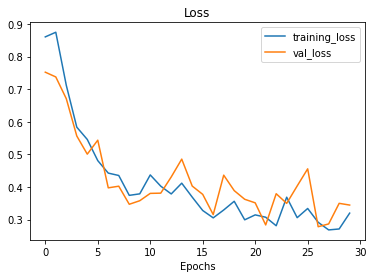

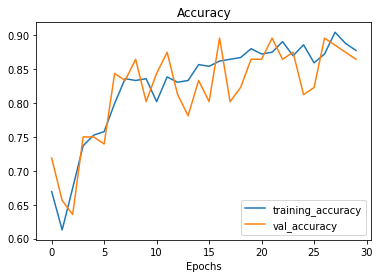

In [29]:
plot_loss_curves(history_1)

There it is.  Model 1 done.  That is the benchmark.  Let's zoom past it.

Our model is actually pretty solid.  It is very jagged though.  Let's add data through data augmentation and keep everything else the same for this model

## Model 2 of 10
* How can we help this?
  - Data augmentation to the rescue?

In [30]:
train_datagen_2 = ImageDataGenerator(rescale = 1. / 255,
                                     rotation_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     fill_mode = "nearest")

test_datagen_2 = ImageDataGenerator(rescale = 1. / 255,
                                    rotation_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    fill_mode = "nearest")

In [31]:
train_data_2 = train_datagen_2.flow_from_directory(train_dir,
                                                   target_size = (299, 299),
                                                   class_mode = "categorical",
                                                   batch_size = 32,
                                                   shuffle = True)

test_data_2 = test_datagen_2.flow_from_directory(test_dir,
                                                 target_size = (299, 299),
                                                 class_mode = "categorical",
                                                 batch_size = 32,
                                                 shuffle = True)

Found 12121 images belonging to 3 classes.
Found 3032 images belonging to 3 classes.


In [32]:
#1. Build the model
model_2 = Sequential([
  Conv2D(10, 3, activation = "relu", input_shape = (299, 299, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation = "relu"),
  MaxPool2D(),
  Conv2D(10, 3, activation = "relu"),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation = "softmax")
])

#2. Compile the model
model_2.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = Adam(),
                metrics = ["accuracy"])

#3. Fit the model
history_2 = model_2.fit(train_data_2,
                        epochs = 30,
                        validation_data = test_data,
                        steps_per_epoch = math.ceil(len(train_data_2) / 32),
                        validation_steps = math.ceil(len(test_data_2) / 32))

Epoch 1/30
12/12 [==============================] - 28s 2s/step - loss: 0.9825 - accuracy: 0.6272 - val_loss: 0.8532 - val_accuracy: 0.6354
Epoch 2/30
12/12 [==============================] - 27s 2s/step - loss: 0.7907 - accuracy: 0.6914 - val_loss: 0.6371 - val_accuracy: 0.8021
Epoch 3/30
12/12 [==============================] - 27s 2s/step - loss: 0.7126 - accuracy: 0.7081 - val_loss: 0.7778 - val_accuracy: 0.6458
Epoch 4/30
12/12 [==============================] - 28s 2s/step - loss: 0.7499 - accuracy: 0.6750 - val_loss: 0.5470 - val_accuracy: 0.7812
Epoch 5/30
12/12 [==============================] - 28s 2s/step - loss: 0.7033 - accuracy: 0.6920 - val_loss: 0.6098 - val_accuracy: 0.6979
Epoch 6/30
12/12 [==============================] - 27s 2s/step - loss: 0.7771 - accuracy: 0.6396 - val_loss: 0.7490 - val_accuracy: 0.5417
Epoch 7/30
12/12 [==============================] - 27s 2s/step - loss: 0.5966 - accuracy: 0.7375 - val_loss: 0.5494 - val_accuracy: 0.7396
Epoch 8/30
12/12 [==

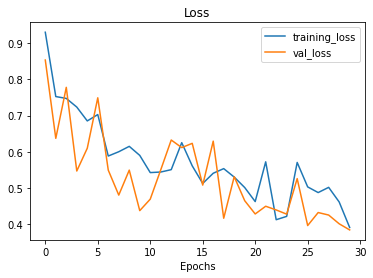

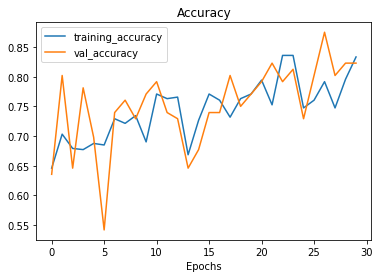

In [33]:
plot_loss_curves(history_2)

## Model 3 of 10
- Data Augmentation seems to have kept this the same.
- Let's go try a different archtiecture this time.

In [34]:
train_datagen_3 = ImageDataGenerator(rescale = 1. / 255,
                                     rotation_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     fill_mode = "nearest")

test_datagen_3 = ImageDataGenerator(rescale = 1. / 255,
                                    rotation_range = 0.2,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    fill_mode = "nearest")

In [35]:
train_data_3 = train_datagen_3.flow_from_directory(train_dir,
                                                   target_size = (299, 299),
                                                   class_mode = "categorical",
                                                   batch_size = 32,
                                                   shuffle = True)

test_data_3 = test_datagen_3.flow_from_directory(test_dir,
                                                 target_size = (299, 299),
                                                 class_mode = "categorical",
                                                 batch_size = 32,
                                                 shuffle = True)

Found 12121 images belonging to 3 classes.
Found 3032 images belonging to 3 classes.


In [36]:
#1 Build the model
model_3 = Sequential([
  Conv2D(32, 3, activation = "relu", input_shape = (299, 299, 3)),
  MaxPool2D(),
  Conv2D(32, 3, activation = "relu"),
  MaxPool2D(),
  Conv2D(32, 3, activation = "relu"),
  MaxPool2D(),
  Conv2D(32, 3, activation = "relu"),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation = "softmax")
])

#2 Compile the model
model_3.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = Adam(),
                metrics = ["accuracy"])

#3 Fit the model
history_3 = model_3.fit(train_data_3,
                        epochs = 30,
                        validation_data = test_data_3,
                        steps_per_epoch = len(train_data_3) / 32,
                        validation_steps = len(test_data_3) / 32)

Epoch 1/30
11/11 [==============================] - 53s 4s/step - loss: 0.9309 - accuracy: 0.5474 - val_loss: 0.7010 - val_accuracy: 0.7188
Epoch 2/30
11/11 [==============================] - 53s 4s/step - loss: 0.8236 - accuracy: 0.6938 - val_loss: 0.7155 - val_accuracy: 0.7396
Epoch 3/30
11/11 [==============================] - 50s 4s/step - loss: 0.8065 - accuracy: 0.6838 - val_loss: 0.7416 - val_accuracy: 0.7188
Epoch 4/30
11/11 [==============================] - 50s 4s/step - loss: 0.6826 - accuracy: 0.7195 - val_loss: 0.7017 - val_accuracy: 0.7188
Epoch 5/30
11/11 [==============================] - 51s 4s/step - loss: 0.6639 - accuracy: 0.6800 - val_loss: 0.4500 - val_accuracy: 0.7917
Epoch 6/30
11/11 [==============================] - 51s 4s/step - loss: 0.6727 - accuracy: 0.6762 - val_loss: 0.5557 - val_accuracy: 0.7604
Epoch 7/30
11/11 [==============================] - 50s 4s/step - loss: 0.6255 - accuracy: 0.7126 - val_loss: 0.6822 - val_accuracy: 0.6250
Epoch 8/30
11/11 [==

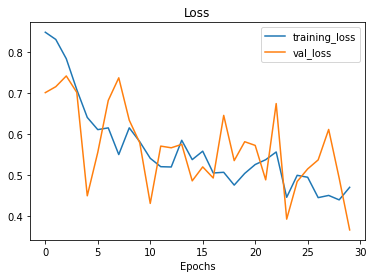

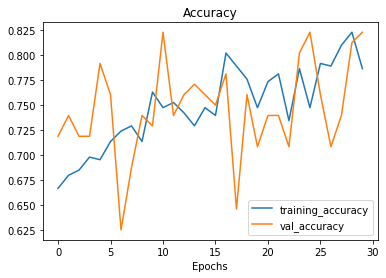

In [37]:
plot_loss_curves(history_3)

## Model 4 of 10

Transfer learning tries.


## Model 5 of 10

## Model 6 of 10 
The class imbalance is now accounted for

# Predictions for each model!